# Manual Matching of a WEST ICRH Antenna on Vacuum

This notebook calculates the charts used in the internal documentation for the IC Operators for the manual matching on vacuum. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import skrf as rf

# WEST ICRH Antenna package
import sys; sys.path.append('..')
from west_ic_antenna import WestIcrhAntenna
#rf.stylely()

# Matching each side separately
For a given RF frequency $f_0$, an antenna can be matched on the left side only, then on the right side only, before using both sides together and shifting the frequency depending on the phase excitation (see [Tutorial on Manual Matching](tutorial_matching_manual.ipynb). A further step can consist of slightly adjusting the four capacitors, to decrease the reflected powers seen by the generators.  

This section calculates the frequency shift to apply depending on the phase excitation and the theoretical capacitance shifts to further apply for additional improvement.

In [8]:
f0_MHzs = np.arange(46, 66, 5)  # decrease the step size to get more precise plots

In [9]:
# frequency scan for dipole and monopole
freq_shift_MHzs_dipo, freq_shift_MHzs_mono = [], []
C_vacuums, C_opt_dipoles, C_opt_monopoles = [], [], []
for f0_MHz in tqdm(f0_MHzs):
    freq = rf.Frequency(f0_MHz, f0_MHz, npoints=1, unit='MHz')
    ant_vacuum = WestIcrhAntenna(frequency=freq)  # default is vacuum coupling
    Cs_left = ant_vacuum.match_one_side(f_match=f0_MHz*1e6, side='left', decimals=2, verbose=False)
    Cs_right = ant_vacuum.match_one_side(f_match=f0_MHz*1e6, side='right', decimals=2, verbose=False)
    Cs = [Cs_left[0], Cs_left[1], Cs_right[2], Cs_right[3]]
    del ant_vacuum  # cleanup mem

    # searching for the frequency shift to apply
    freqs = rf.Frequency(f0_MHz - 1, f0_MHz + 1, npoints=201, unit='MHz')
    ant = WestIcrhAntenna(frequency=freqs)

    # dipole
    s_act = np.abs(ant.s_act(Cs=Cs, power=[1,1], phase=[0,np.pi]))
    f_opt_dipole = freqs.f_scaled[np.argmin(s_act[:,0])] # assume same at right
    freq_shift_MHzs_dipo.append(f_opt_dipole - f0_MHz)
    
    # monopole
    s_act = np.abs(ant.s_act(Cs=Cs, power=[1,1], phase=[0,0]))
    f_opt_monopole = freqs.f_scaled[np.argmin(s_act[:,0])]
    freq_shift_MHzs_mono.append(f_opt_monopole - f0_MHz)

    # Finally determining the optimum set of capacitance
    # for the dipole or monopole case
    C_opt_dipole = ant.match_both_sides(f_match=f_opt_dipole*1e6, decimals=2, power=[1,1], phase=[0,np.pi], verbose=False)
    C_opt_monopole = ant.match_both_sides(f_match=f_opt_monopole*1e6, decimals=2, power=[1,1], phase=[0,0], verbose=False)
    del ant  # memory cleanup
    
    C_vacuums.append(Cs)
    C_opt_dipoles.append(C_opt_dipole)
    C_opt_monopoles.append(C_opt_monopole)

freq_shift_MHzs_dipo = np.array(freq_shift_MHzs_dipo)
freq_shift_MHzs_mono = np.array(freq_shift_MHzs_mono)
C_vacuums = np.array(C_vacuums)
C_opt_dipoles = np.array(C_opt_dipoles)
C_opt_monopoles = np.array(C_opt_monopoles)

  0%|          | 0/19 [00:00<?, ?it/s]

The frequency shift to apply for dipole and monopole configurations are:

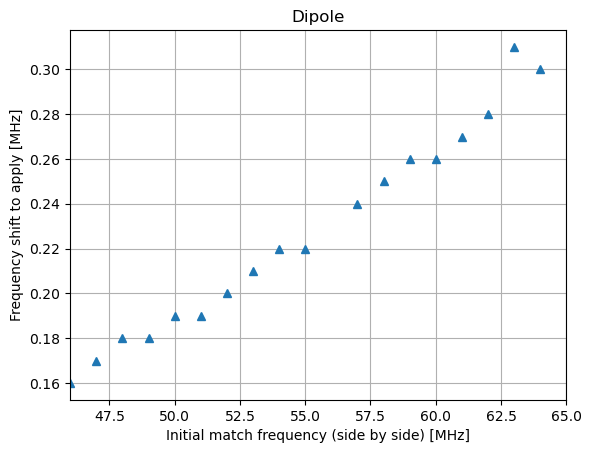

In [10]:
fig, ax = plt.subplots()
ax.plot(f0_MHzs[freq_shift_MHzs_dipo>0.1], freq_shift_MHzs_dipo[freq_shift_MHzs_dipo>0.1], marker='^', ls='')
ax.set_xlabel('Initial match frequency (side by side) [MHz]')
ax.set_ylabel('Frequency shift to apply [MHz]')
ax.set_title('Dipole')
ax.set_xlim(46, 65)
ax.grid(True)

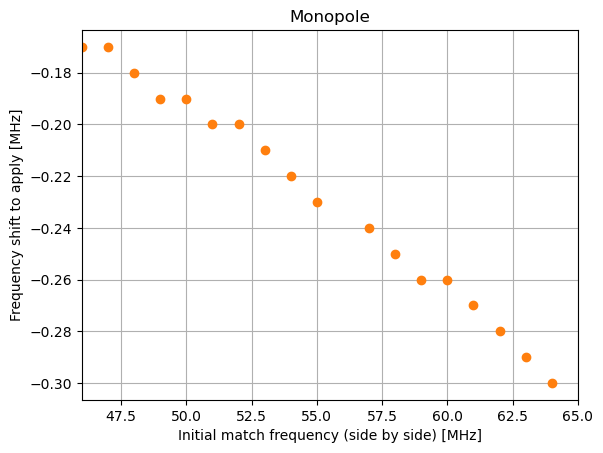

In [11]:
fig, ax = plt.subplots()
ax.plot(f0_MHzs[freq_shift_MHzs_mono<-0.1], freq_shift_MHzs_mono[freq_shift_MHzs_mono<-0.1], marker='o', ls='', color='C1')
ax.set_xlabel('Initial match frequency (side by side) [MHz]')
ax.set_ylabel('Frequency shift to apply [MHz]')
ax.set_title('Monopole')
ax.set_xlim(46, 65)
ax.grid(True)

The capacitor shift

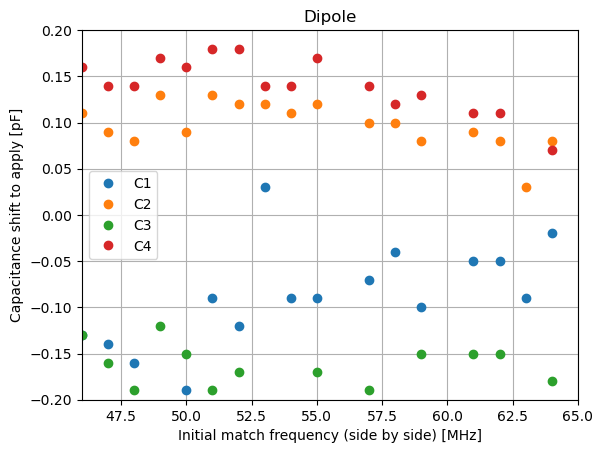

In [21]:
diff_dipole = C_opt_dipoles - C_vacuums

fig, ax = plt.subplots()
ax.plot(f0_MHzs, diff_dipole[:,0], marker='o', ls='', color='C0', label='C1')
ax.plot(f0_MHzs, diff_dipole[:,1], marker='o', ls='', color='C1', label='C2')
ax.plot(f0_MHzs, diff_dipole[:,2], marker='o', ls='', color='C2', label='C3')
ax.plot(f0_MHzs, diff_dipole[:,3], marker='o', ls='', color='C3', label='C4')

ax.set_xlabel('Initial match frequency (side by side) [MHz]')
ax.set_ylabel('Capacitance shift to apply [pF]')
ax.set_title('Dipole')
ax.set_xlim(46, 65)
ax.set_ylim(-0.2, +0.2)
ax.legend()
ax.grid(True)

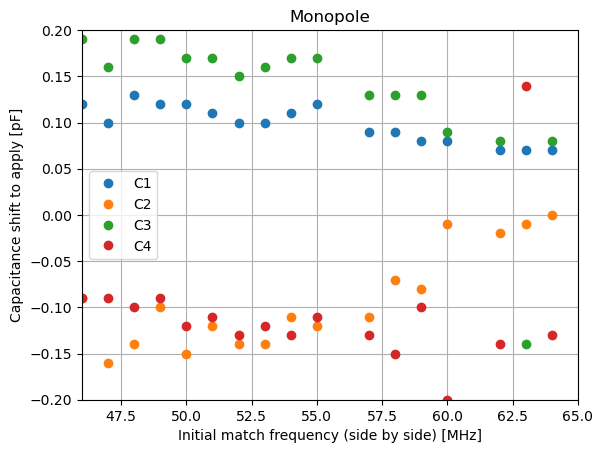

In [22]:
diff_dipole = C_opt_monopoles - C_vacuums

fig, ax = plt.subplots()
ax.plot(f0_MHzs, diff_dipole[:,0], marker='o', ls='', color='C0', label='C1')
ax.plot(f0_MHzs, diff_dipole[:,1], marker='o', ls='', color='C1', label='C2')
ax.plot(f0_MHzs, diff_dipole[:,2], marker='o', ls='', color='C2', label='C3')
ax.plot(f0_MHzs, diff_dipole[:,3], marker='o', ls='', color='C3', label='C4')

ax.set_xlabel('Initial match frequency (side by side) [MHz]')
ax.set_ylabel('Capacitance shift to apply [pF]')
ax.set_title('Monopole')
ax.set_xlim(46, 65)
ax.set_ylim(-0.2, +0.2)
ax.legend()
ax.grid(True)